6 December 2023

https://carmengg.github.io/eds-220-book/lectures/lesson-22-make_a_gif.html

# Make a GIF

In this lesson we will use NAIP data to create a GIF showing vegetation change over Campus Point at UCSB.

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import xarray as xr
import rioxarray as rioxr
from shapely.geometry import box

import pystac_client
import planetary_computer

from geogif import gif  # to create gif

## Data Search

In [3]:
# open catalog
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# coords defining bbox around campus point
bbox = [-119.84682486219316, 34.404860394049024, -119.84370917948988, 34.40632764289684]

# search 
search = catalog.search(
    collections=["naip"], 
    bbox=bbox, 
    datetime='2016/2023'
)

# get items from search
items = search.item_collection()
print(f'There are {len(items)} items in the search.')

There are 3 items in the search.


## Prepare Raster

In [4]:
item = items[0]
sb = rioxr.open_rasterio(item.assets['image'].href)
sb

<xarray.DataArray (band: 4, y: 12500, x: 10580)>
[529000000 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1 2 3 4
  * x            (x) float64 2.354e+05 2.354e+05 ... 2.418e+05 2.418e+05
  * y            (y) float64 3.815e+06 3.815e+06 ... 3.807e+06 3.807e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:             Area
    TIFFTAG_IMAGEDESCRIPTION:  OrthoVista
    TIFFTAG_RESOLUTIONUNIT:    1 (unitless)
    TIFFTAG_SOFTWARE:          Trimble Germany GmbH
    TIFFTAG_XRESOLUTION:       1
    TIFFTAG_YRESOLUTION:       1
    _FillValue:                0
    scale_factor:              1.0
    add_offset:                0.0

<Axes: >

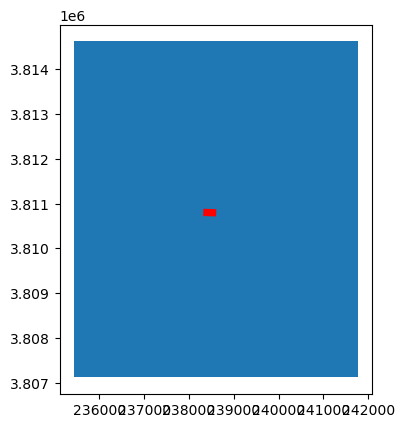

In [5]:
# bounding box as geodataframe
box_df = gpd.GeoDataFrame(geometry=[box(*bbox)],
                 crs='epsg:4326') 

# plot bounding box and raster extents
fig, ax = plt.subplots()
gpd.GeoDataFrame(geometry=[box(*sb.rio.bounds())],
                 crs=sb.rio.crs).plot(ax=ax)
box_df.to_crs(sb.rio.crs).plot(ax=ax, color='red')

In [6]:
# clip raster to bounding box
sb = sb.rio.clip_box(*box_df.to_crs(sb.rio.crs).total_bounds)

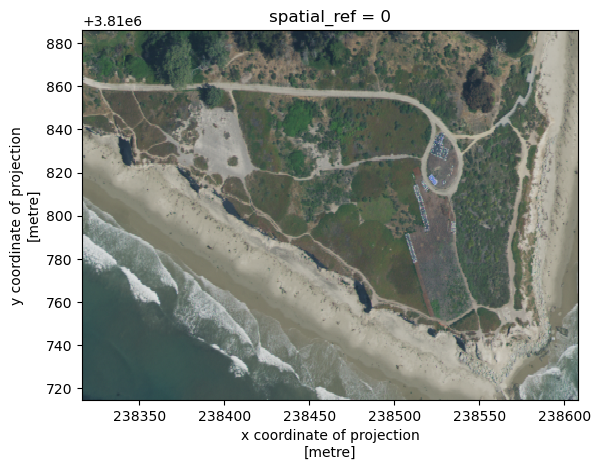

In [7]:
# select red, green, blue bands and plot true color image.
sb = sb.sel(band=[1,2,3])
sb.plot.imshow()

## Stack Rasters

In [8]:
# create a list with rasters
rasters = []
for item in items:
    sb = rioxr.open_rasterio(item.assets['image'].href)
    sb = sb.rio.clip_box(*box_df.to_crs(sb.rio.crs).total_bounds)
    sb = sb.sel(band=[1,2,3])
    rasters.append(sb)

In [9]:
# concatenate rasters into single xarray.DataArray
stack = xr.concat(rasters, dim='time')
stack

<xarray.DataArray (time: 3, band: 3, y: 286, x: 486)>
array([[[[ 96, 109,  96, ..., 133, 147, 148],
         [108,  99,  87, ..., 134, 145, 150],
         [110, 109, 101, ..., 123, 142, 150],
         ...,
         [ 37,  37,  37, ..., 150, 130, 158],
         [ 36,  38,  37, ..., 158, 135, 137],
         [ 37,  38,  38, ..., 151, 145, 116]],

        [[105, 112, 107, ..., 130, 146, 146],
         [113, 106,  94, ..., 136, 142, 147],
         [113, 109, 107, ..., 128, 141, 148],
         ...,
         [ 58,  59,  60, ..., 161, 153, 167],
         [ 56,  58,  59, ..., 173, 156, 158],
         [ 58,  58,  59, ..., 166, 157, 137]],

        [[ 93, 105,  99, ..., 121, 130, 128],
         [ 88,  88,  85, ..., 120, 128, 131],
         [ 87,  86,  84, ..., 113, 127, 133],
         ...,
...
         ...,
         [ 45,  46,  39, ...,  61,  64,  59],
         [ 57,  64,  36, ...,  63,  55,  53],
         [ 53,  57,  40, ...,  55,  50,  46]],

        [[ 48,  46,  49, ...,  90,  90,  99],
         [ 48,  47,  49, ...,  88,  92, 120],
         [ 54,  49,  49, ...,  85, 112, 114],
         ...,
         [ 58,  58,  57, ...,  70,  76,  74],
         [ 73,  70,  53, ...,  76,  70,  66],
         [ 65,  69,  52, ...,  68,  59,  60]],

        [[ 51,  51,  53, ...,  85,  86, 109],
         [ 52,  52,  53, ...,  85,  99, 119],
         [ 54,  51,  55, ...,  81, 109, 108],
         ...,
         [ 70,  68,  62, ...,  79,  79,  76],
         [ 78,  75,  61, ...,  81,  72,  70],
         [ 71,  77,  63, ...,  74,  66,  65]]]], dtype=uint8)
Coordinates:
  * band         (band) int64 1 2 3
  * x            (x) float64 2.383e+05 2.383e+05 ... 2.386e+05 2.386e+05
  * y            (y) float64 3.811e+06 3.811e+06 ... 3.811e+06 3.811e+06
    spatial_ref  int64 0
Dimensions without coordinates: time
Attributes:
    AREA_OR_POINT:             Area
    TIFFTAG_IMAGEDESCRIPTION:  OrthoVista
    TIFFTAG_RESOLUTIONUNIT:    1 (unitless)
    TIFFTAG_SOFTWARE:          Trimble Germany GmbH
    TIFFTAG_XRESOLUTION:       1
    TIFFTAG_YRESOLUTION:       1
    scale_factor:              1.0
    add_offset:                0.0
    _FillValue:                0

In [10]:
# year of collection of an item 
item = items[0]
item.properties['naip:year']

'2020'

In [11]:
# convert strings to datetime
pd.to_datetime(item.properties['naip:year'])

Timestamp('2020-01-01 00:00:00')

In [12]:
times = [pd.to_datetime(item.properties['naip:year']) for item in items]
times

[Timestamp('2020-01-01 00:00:00'),
 Timestamp('2018-01-01 00:00:00'),
 Timestamp('2016-01-01 00:00:00')]

In [13]:
stack = stack.assign_coords(time=times).sortby("time")
stack

<xarray.DataArray (time: 3, band: 3, y: 286, x: 486)>
array([[[[ 51,  48,  49, ...,  98,  96, 114],
         [ 54,  49,  52, ...,  96,  96, 122],
         [ 59,  51,  55, ...,  90, 119, 112],
         ...,
         [ 45,  46,  39, ...,  61,  64,  59],
         [ 57,  64,  36, ...,  63,  55,  53],
         [ 53,  57,  40, ...,  55,  50,  46]],

        [[ 48,  46,  49, ...,  90,  90,  99],
         [ 48,  47,  49, ...,  88,  92, 120],
         [ 54,  49,  49, ...,  85, 112, 114],
         ...,
         [ 58,  58,  57, ...,  70,  76,  74],
         [ 73,  70,  53, ...,  76,  70,  66],
         [ 65,  69,  52, ...,  68,  59,  60]],

        [[ 51,  51,  53, ...,  85,  86, 109],
         [ 52,  52,  53, ...,  85,  99, 119],
         [ 54,  51,  55, ...,  81, 109, 108],
         ...,
...
         ...,
         [ 37,  37,  37, ..., 150, 130, 158],
         [ 36,  38,  37, ..., 158, 135, 137],
         [ 37,  38,  38, ..., 151, 145, 116]],

        [[105, 112, 107, ..., 130, 146, 146],
         [113, 106,  94, ..., 136, 142, 147],
         [113, 109, 107, ..., 128, 141, 148],
         ...,
         [ 58,  59,  60, ..., 161, 153, 167],
         [ 56,  58,  59, ..., 173, 156, 158],
         [ 58,  58,  59, ..., 166, 157, 137]],

        [[ 93, 105,  99, ..., 121, 130, 128],
         [ 88,  88,  85, ..., 120, 128, 131],
         [ 87,  86,  84, ..., 113, 127, 133],
         ...,
         [ 69,  69,  70, ..., 155, 148, 161],
         [ 67,  69,  70, ..., 169, 151, 152],
         [ 69,  70,  68, ..., 166, 156, 135]]]], dtype=uint8)
Coordinates:
  * band         (band) int64 1 2 3
  * x            (x) float64 2.383e+05 2.383e+05 ... 2.386e+05 2.386e+05
  * y            (y) float64 3.811e+06 3.811e+06 ... 3.811e+06 3.811e+06
    spatial_ref  int64 0
  * time         (time) datetime64[ns] 2016-01-01 2018-01-01 2020-01-01
Attributes:
    AREA_OR_POINT:             Area
    TIFFTAG_IMAGEDESCRIPTION:  OrthoVista
    TIFFTAG_RESOLUTIONUNIT:    1 (unitless)
    TIFFTAG_SOFTWARE:          Trimble Germany GmbH
    TIFFTAG_XRESOLUTION:       1
    TIFFTAG_YRESOLUTION:       1
    scale_factor:              1.0
    add_offset:                0.0
    _FillValue:                0

## GIF

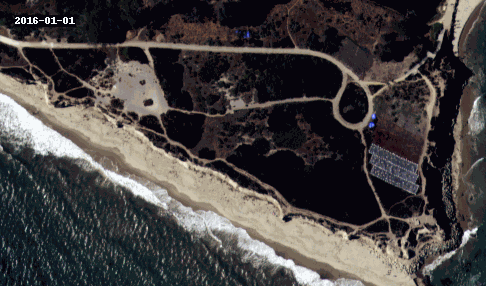

In [14]:
# create gif
# fps = frames per second
# adding to="campus_point.gif" will save GIF
gif(stack, fps = 0.5)